In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mypackage import SemiLag, LatLonGrid

In [2]:
n = 90
grid = LatLonGrid(n)

### wind generation

In [3]:
wind = grid.isotropic_grf(3,alpha=0.65)

wind -= (wind * grid.e_r).sum(axis=0) * grid.e_r ## removing the normal component of the wind

wind = wind/np.linalg.norm(wind,axis=0).max()
max_wind_speed = 130 #kmh
D = 6370 #earth radius in km
wind = wind/D * max_wind_speed

/home/perrota/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


### initializing an ensemble :

In [97]:
N = 400
x0 = grid.isotropic_grf(1)
sigma0 = 0.01 * (10+grid.isotropic_grf(1))
ens0 = x0 + sigma0*grid.isotropic_grf(N)

/home/perrota/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


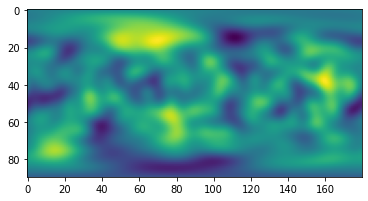

In [111]:
plt.imshow(x0.T)

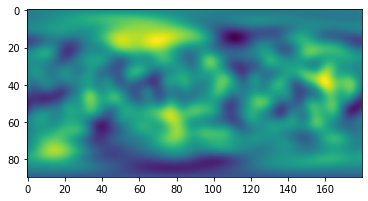

In [112]:
plt.imshow(ens0.mean(axis=0).T)

#### forecast

In [114]:
model = SemiLag(n, wind, dt=.25)

t_end = 24
forecast = model.forecast(ens0,  t_end, time_saving_interval=1)

100%|██████████| 96/96 [00:18<00:00,  5.10it/s]


In [115]:
en_out = forecast[t_end]
mean, std, aspect_tensor = grid.ensemble_diagnosis(en_out)

/home/perrota/Documents/spherical-advection/mypackage/tools/LatLonGrid.py:157: RuntimeWarning: divide by zero encountered in true_divide
  aspect_tensor =1/(metric_tensor[0,0] * metric_tensor[1,1] - metric_tensor[0,1]**2) * np.array([[metric_tensor[1,1],-metric_tensor[0,1]],
/home/perrota/Documents/spherical-advection/mypackage/tools/LatLonGrid.py:157: RuntimeWarning: invalid value encountered in multiply
  aspect_tensor =1/(metric_tensor[0,0] * metric_tensor[1,1] - metric_tensor[0,1]**2) * np.array([[metric_tensor[1,1],-metric_tensor[0,1]],


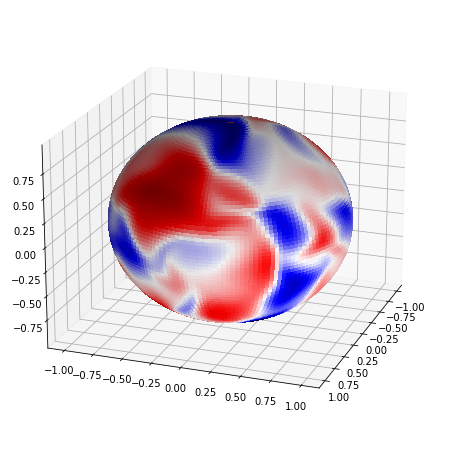

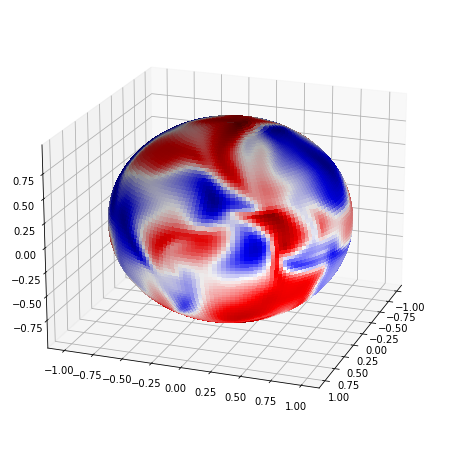

In [116]:
grid.sphere_plot(mean,figsize=(8,8));
grid.sphere_plot(std, figsize=(8,8));

## PKF on the sphere :

In [117]:
forecast_mean = model.forecast(x0,t_end,time_saving_interval=1)
forecast_std = model.forecast(sigma0, t_end, time_saving_interval=1)

100%|██████████| 96/96 [00:00<00:00, 348.80it/s]


In [118]:
out_mean = forecast_mean[t_end][0]
out_std = forecast_std[t_end][0]

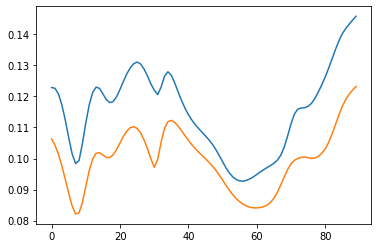

In [124]:
plt.plot(std[50])
plt.plot(out_std[50])

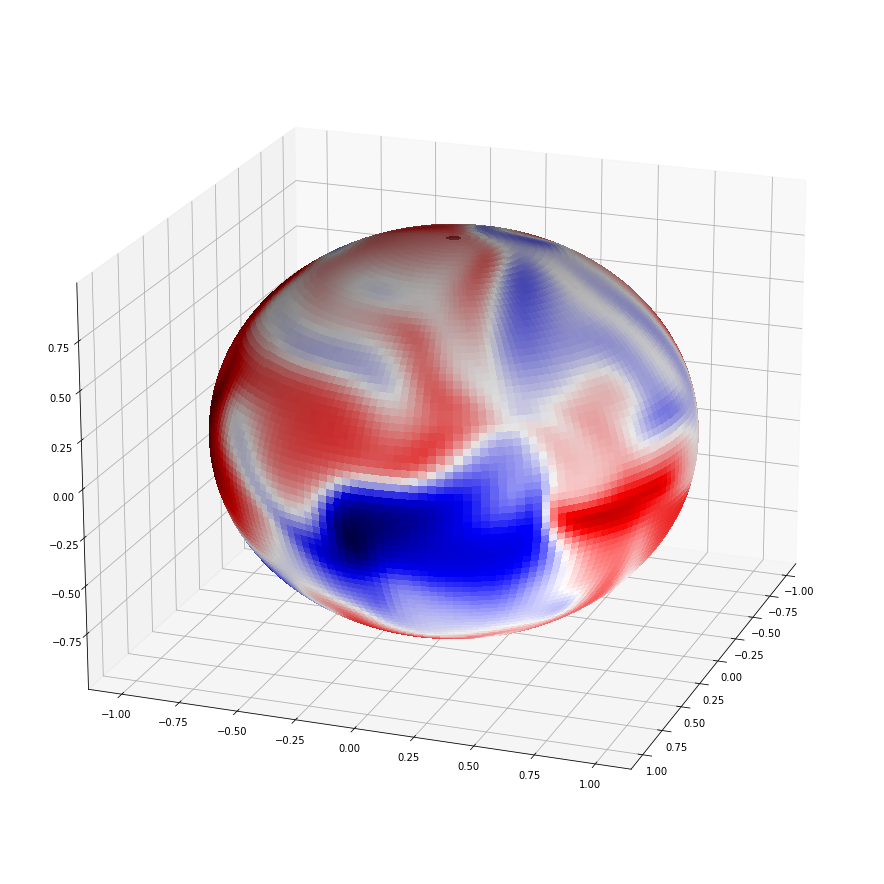

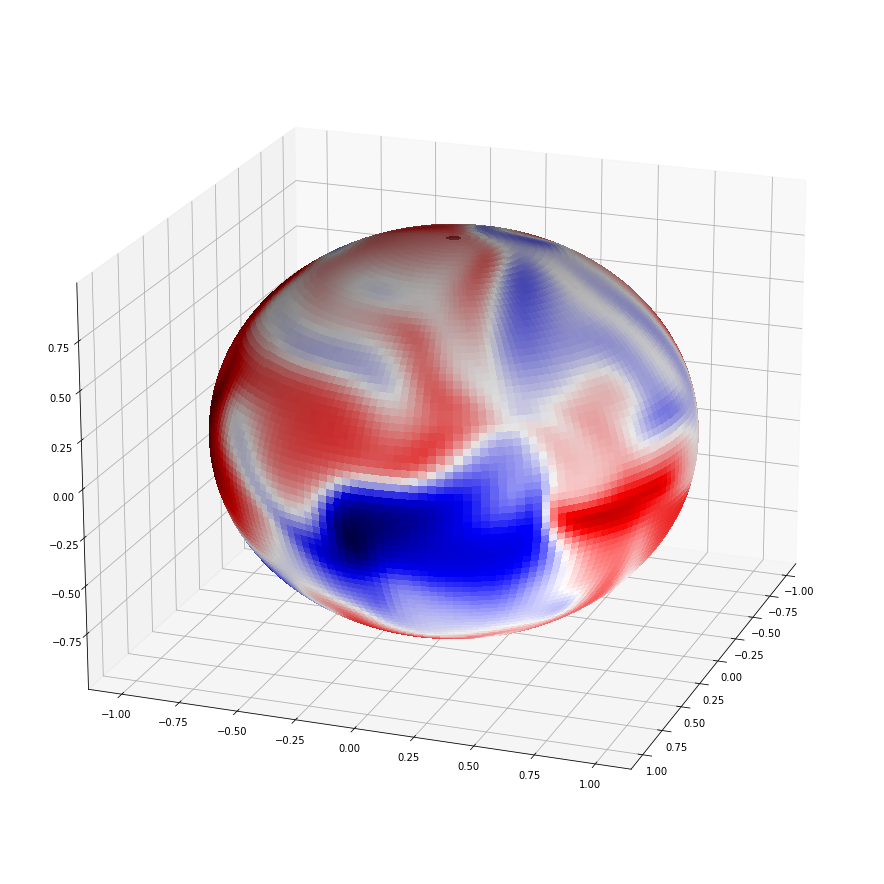

In [94]:
grid.sphere_plot(out_std)

In [16]:
def gradient_sphere(field):
    d_phi =  ((np.roll(field,-1,axis=0) - np.roll(field,1,axis=0))/2/dphi ) / np.cos(theta)
    d_theta =  ((np.roll(field,-1,axis=1) - np.roll(field,1,axis=1))/2/dtheta )
    d_phi[:,[0,n-1]] = 0
    d_theta[:,[0,n-1]] = 0

    return d_theta,d_phi

In [17]:
from mypackage.problem import Model
class PKFSphericalAdvection(Model):
    def _make_trend(self):
        wind = self.trend_parameters[0]
        wind_x, wind_y, wind_z = wind 
        
        self.wind_theta = (wind*e_theta).sum(axis=0)
        self.wind_phi   = (wind*e_phi).sum(axis=0)
        
        self.dtheta_wtheta, self.dphi_wtheta = gradient_sphere(self.wind_theta)
        self.dtheta_wphi, self.dphi_wphi = gradient_sphere(self.wind_phi)
        
        
        # computing departures points in R^3 :
        Xd = X - self.dt*wind_x
        Yd = Y - self.dt*wind_y
        Zd = Z - self.dt*wind_z
        
        # projecting them onto the sphere (approximation) :
        norm_d = np.linalg.norm(np.array([Xd,Yd,Zd]),axis=0)
        Xd = Xd/norm_d
        Yd = Yd/norm_d
        Zd = Zd/norm_d
        
        #converting them to (theta,phi) system of coordinates :
        phid = np.arctan2(Yd,Xd)
        thetad = np.arcsin( Zd/(Xd**2+Yd**2+Zd**2)**.5)

        #getting their indices :
        self.PHId = ((phid + np.pi)/(2*np.pi) * (m))  #* 0.999999
        self.THETAd = ((thetad + np.pi/2)/(np.pi) * (n-1))
        
        
        def trend(state,t):
            x, std, s_xx, s_xy, s_yy = state
            
            trend_x,trend_std = x*0, std*0
            trend_s_xx = 2*( s_xx * self.dtheta_wtheta + s_xy * self.dphi_wtheta)
            trend_s_xy = s_xx * self.dtheta_wphi + s_xy * self.dtheta_wtheta + s_xy * self.dphi_wphi + s_yy* self.dphi_wtheta
            trend_s_yy = 2*( s_yy * self.dphi_wphi + s_xy * self.dtheta_wphi)
            
            trend_out = np.array([trend_x,trend_std, trend_s_xx, trend_s_xy, trend_s_yy])            
            return trend_out

        return trend
        
    def _step(self, new_dt=None):
        x, std, s_xx, s_xy, s_yy  = BilinearSpherical(self.THETAd, self.PHId, self.x)
        
        
        temp_state = np.array([x, std, s_xx, s_xy, s_yy])  ## applied advection process using Semi-Lagrangian method
        self.x = self.scheme.step(self.trend, temp_state, self.t,self.dt)
        
        #saving :
        self.t += self.dt
        if self.save and (self.time_saving_interval =="all"  or self.t - self.last_saved_time >= self.time_saving_interval) :
            self.saved_times.append(self.t)
            self.trajectory[self.t] = self.x
            self.last_saved_time = self.t

In [18]:
pkf = PKFSphericalAdvection(pkf_state0, trend_parameters=[wind], dt = .25, save = False, scheme ='RK4')

In [19]:
pkf.forecast(t_end)

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:06<00:00, 10.77it/s]


Mean field 0.00%
Standard deviation 4.38%
$\mathbf{s}_{\theta \theta}$ 25.29%
$\mathbf{s}_{\theta \phi}$ 56.06%
$\mathbf{s}_{\phi \phi}$ 56.66%


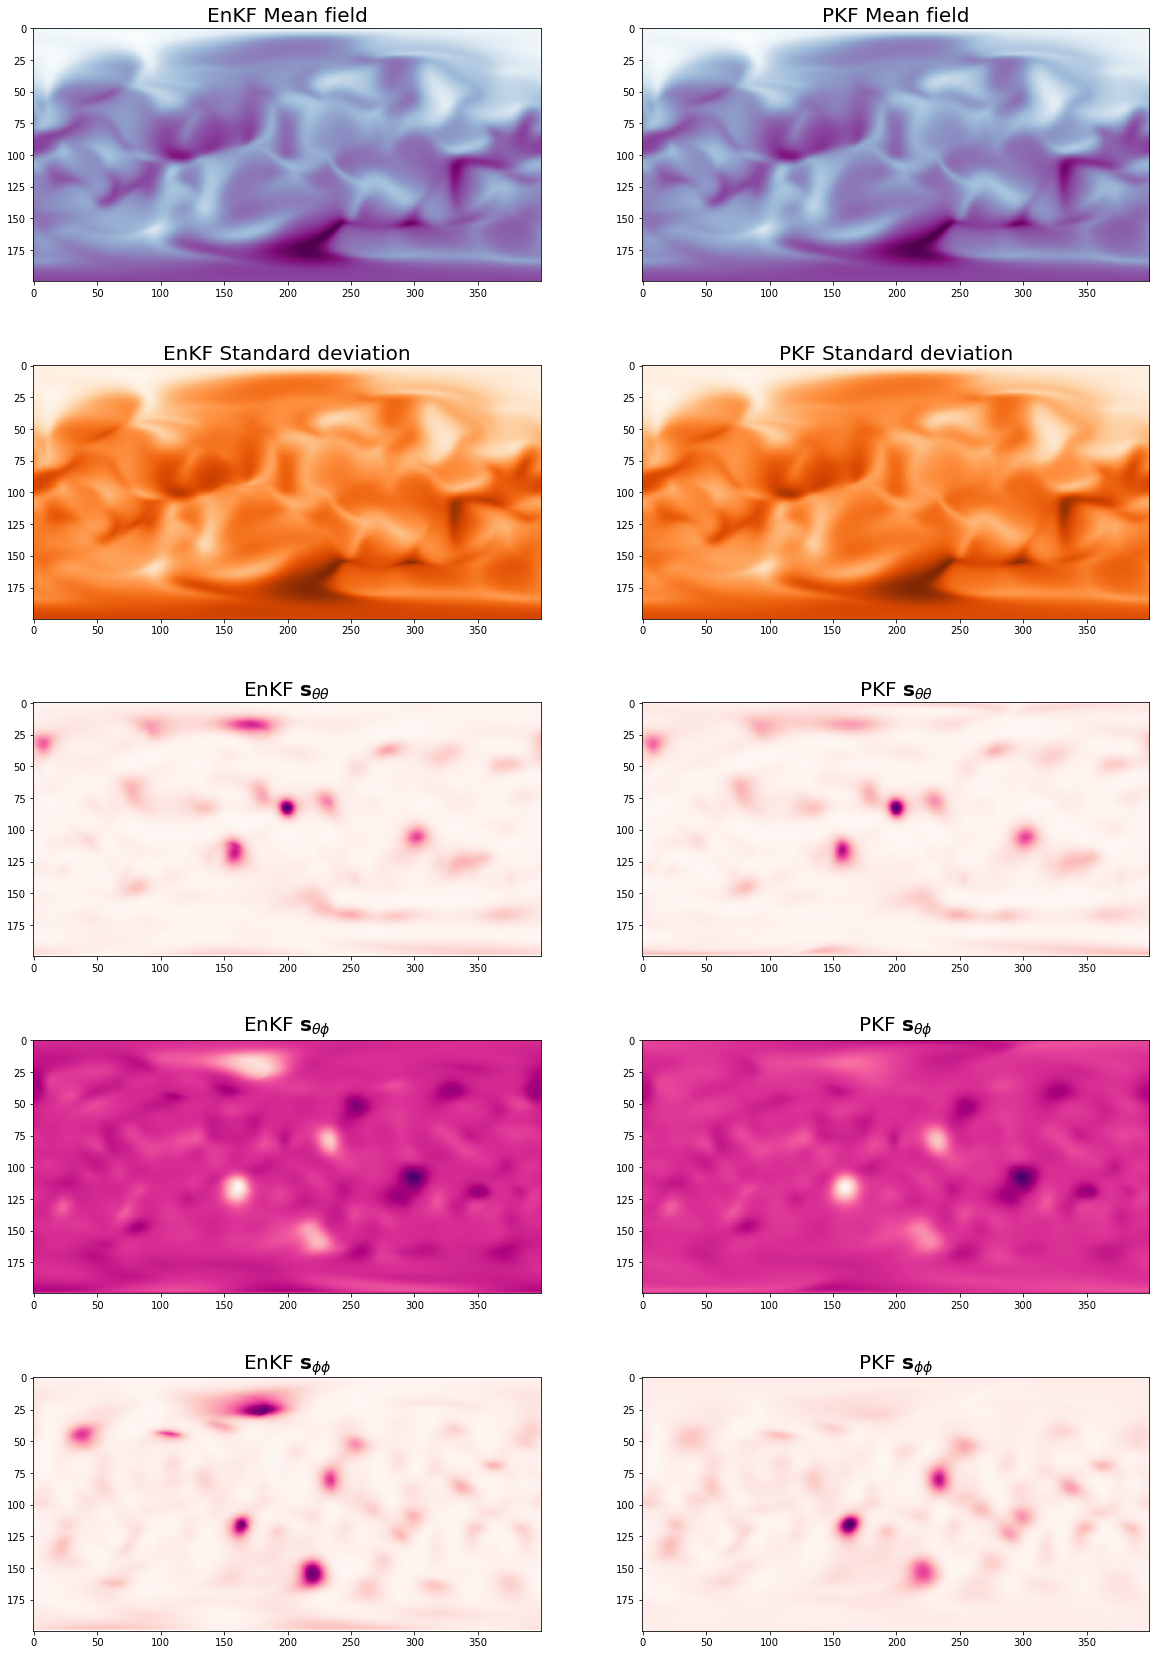

In [274]:
plt.figure(figsize=(20,30))
titles = ['Mean field','Standard deviation',r'$\mathbf{s}_{\theta \theta}$',
         r'$\mathbf{s}_{\theta \phi}$',
         r'$\mathbf{s}_{\phi \phi}$']

cmaps = [cm.BuPu, cm.Oranges, cm.RdPu,cm.RdPu,cm.RdPu]

fz = 20
for i, (enkf_field, pkf_field, title,cmap) in enumerate(zip(
    [mean, std, aspect_tensor[0,0],aspect_tensor[0,1],aspect_tensor[1,1]],
                                         pkf.x,
                                         titles,cmaps)):
    
    print(title + " {:.2f}%".format(np.linalg.norm(enkf_field - pkf_field)*100/np.linalg.norm(enkf_field)))
    plt.subplot(5,2,2*i +1)
    plt.title('EnKF '+title,fontsize=fz)
    plt.imshow(enkf_field.T,cmap=cmap)
    
    plt.subplot(5,2,2*i +2)
    plt.title('PKF ' + title,fontsize=fz)
    plt.imshow(pkf_field.T,cmap=cmap)

## correlation functions :

In [55]:
def cor_func(ensemble, r_PHI, r_THETA):
    mean = ensemble.mean(axis=0)
    std = ensemble.std(axis=0)
    errors = (ensemble - mean)
    
    cov_func = (errors *errors[:,r_PHI, r_THETA][np.newaxis,np.newaxis].T).mean(axis=0)
    
    cor_func = cov_func / (std * std[r_PHI, r_THETA])
    return cor_func

In [172]:
def cor_func_model(aspect_tensor, r_PHI, r_THETA):
    
    det = (aspect_tensor[0,0] * aspect_tensor[1,1] - aspect_tensor[0,1]**2)
    sum_aspect_tensor = aspect_tensor + aspect_tensor[:,:,r_PHI,r_THETA][:,:,np.newaxis,np.newaxis]
    det_sum = 0.5**2 *(sum_aspect_tensor[0,0] * sum_aspect_tensor[1,1] - sum_aspect_tensor[0,1]**2)
    
    
    metric_tensor =1/det * np.array([[aspect_tensor[1,1],-aspect_tensor[0,1]],
         [-aspect_tensor[0,1], aspect_tensor[0,0]]])
    metric_tensor[:,:,:,[0,-1]] = 0
    
    diff = np.array([
        (theta - theta[r_PHI, r_THETA] + np.pi/2) % np.pi - np.pi/2,
        (phi - phi[r_PHI, r_THETA] + np.pi) % (2*np.pi) - np.pi
    ])
    
    temp = np.array([
        metric_tensor[0,0] * diff[0] + metric_tensor[0,1] * diff[1],
        metric_tensor[0,1] * diff[0] + metric_tensor[1,1] * diff[1]
    ])
    
    
    
    met_dist = diff[0] * temp[0] + diff[1] * temp[1] 
    
    
    cor_func_pkf = np.exp(-met_dist)  * det**.25 * det[r_PHI, r_THETA] **.25 / (det_sum)**.5
    
    return cor_func_pkf
    


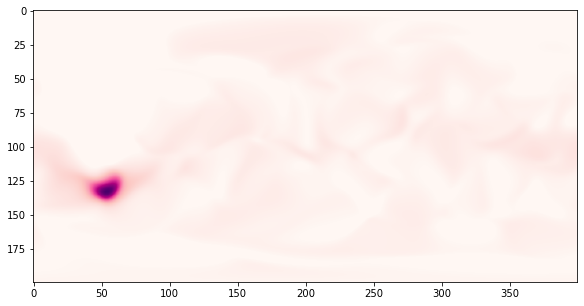

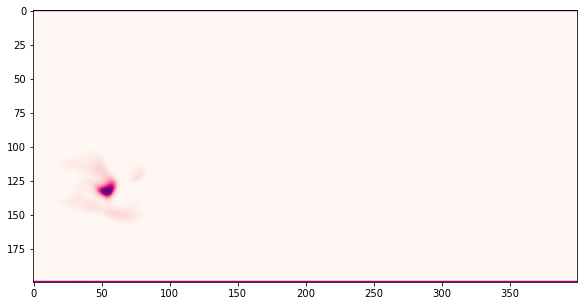

In [241]:
plt.figure(figsize=(16,5))
from random import choice
r_PHI, r_THETA = choice(range(m)), choice(range(int(0.2*n), int(0.8*n)))

cf = cor_func(enkf.x, r_PHI, r_THETA)

plt.imshow(cf.T,vmin=0,vmax=1,cmap ='RdPu')

cf_pkf = cor_func_model(aspect_tensor_pkf, r_PHI, r_THETA)
plt.show()
plt.figure(figsize=(16,5))

plt.imshow(cf_pkf.T,vmin=0,vmax=1,cmap ='RdPu');

Length-scales forecasted by the PKF are shorter than those forecasted by the EnKF. But, looking at the standard deviation field, which follow the same dynamics as the mean concentration, it appears that there is a loss of variance in the EnKF. This might be due to the fact that our advection scheme is diffusive. We know that the diffusion process has the effect to increase the length-scales. This can be part of the explanation of the difference that occur between the length-scales diagnosed by the EnKF with those forecasted by the PKF.